In [1]:
import torch
from torch import nn
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

# 暂退法（Dropout）

## Dropout的基本原理

### 均方误差的再认识

- 考虑均方误差（MSE），预测值为$\hat{y}$，真实值为$y$，则$MSE=E[(\hat{y}-y)^2]$

- 将MSE拆解

$$
\begin{aligned} 
MSE &= E[\hat{y}^2-2\hat{y}y+y^2]\\
&= E[\hat{y}^2]-2E[\hat{y}y]+E[y^2]\\
&= E[\hat{y}^2]-(E[\hat{y}])^2+(E[\hat{y}])^2-2E[\hat{y}y]+E[y^2]\\
&= \mathbf{Var}(\hat{y})+(E[\hat{y}])^2-2E[\hat{y}y]+E[y^2]
\end{aligned}
$$


$$
\begin{aligned} 
MSE &= \mathbf{Var}(\hat{y})+(E[\hat{y}])^2-2yE[\hat{y}]+y^2\\
&= \mathbf{Var}(\hat{y})+(E[\hat{y}]-y)^2\\
&= \text{误差(variance)}+\text{偏差(bias)}^2  
\end{aligned}
$$

- 误差和偏差的组合

<center><img src="../img/4_multilayer-perceptrons/bullseyebiasvariance.png" width=60%></center>

\begin{definition}\label{def:biasVariance}
**偏差-方差权衡**（bias-variance tradeoff）：模型的泛化性和灵活性之间的权衡。
\end{definition}


- 重新再审视模型容量与过拟合

<center><img src="../img/4_multilayer-perceptrons/capacityoverfitting.png" width=60%></center>

|比较|偏差|方差|
|:---:|:---:|:---:|
|线性模型|高|低|
|深度神经网络|低|高|

- 经典泛化理论认为，为了缩小训练和测试性能之间的差距，应该以简单的模型为目标。
    - 简单性以**较小维度**的形式展现

- 简单性的实现方法
    - 权重衰减（$L_2$正则化）
    - 增加平滑性：函数不应该对其输入的微小变化敏感

- 数学上证明了*要求函数光滑*和*要求函数对输入的随机噪声具有适应性*之间的联系

- Tikhonov（吉洪诺夫）正则化：
$$
\underset{w}{\min} ||X^Tw-y||^2+||\Gamma w||^2
$$

- 当$\Gamma=\alpha I$，上述正则变为L2正则

- Tikhonov正则的目的是解决不带正则项的优化问题解不存在或不唯一的情况

- Tikhonov的解是

$$
w = (X^TX+\Gamma^T\Gamma)^{-1}X^Ty
$$

- 将上述关系应用到实践：

> 在训练过程中，在计算后续层之前向网络的每一层注入噪声，实现在输入-输出映射上增强平滑性

\begin{definition}\label{def:dropout}
**暂退法**：在前向传播过程中，计算每一内部层的同时注入噪声。在训练过程中丢弃（drop out）一些神经元，即在计算下一层之前将当前层中的一些节点置零。
\end{definition}


- 如何注入噪声？

- 一种方式，在输入数据中注入噪声，假设输为$X$，噪声为$\varepsilon\sim \mathcal{N}(0,\sigma^2)$

$$
X' = X+\varepsilon
$$

此时，

$$E[X']=X$$

假设有10个样本点，需要用多项式函数拟合

<div class="row">
    <div class="col-md-4">
        <img src="../img/4_multilayer-perceptrons/samplepoints.png" width=100%>
        <p class="text-center">原始数据点</p>
    </div>
    <div class="col-md-4">
        <img src="../img/4_multilayer-perceptrons/samplepointsnfit.png" width=100%>
        <p class="text-center">高次函数</p>
    </div>
    <div class="col-md-4">
        <img src="../img/4_multilayer-perceptrons/samplepoints2fit.png" width=100%>
        <p class="text-center">二次函数</p>
    </div>
</div>

对增加扰动数据的拟合

<div class="row">
    <div class="col-md-4">
        <img src="../img/4_multilayer-perceptrons/samplepointsperturbation.png" width=100%>
        <p class="text-center">增加扰动</p>
    </div>
    <div class="col-md-4">
        <img src="../img/4_multilayer-perceptrons/samplepointsnfit2.png" width=100%>
        <p class="text-center">高次函数</p>
    </div>
    <div class="col-md-4">
        <img src="../img/4_multilayer-perceptrons/samplepoints2fit2.png" width=100%>
        <p class="text-center">二次函数</p>
    </div>
</div>

- 注入噪声的另一种方式，在隐藏层中注入噪声，假设隐藏层的输出向量为$h$，噪声为$\varepsilon\sim\text{Bernoulli}(p)$,
$$
h' = h\varepsilon
$$

此时，

$$E[h']=h$$

- 在标准丢弃正则化中，每一层都会剔除一部分节点，然后通过对保留(未丢弃)的节点进行归一化来消除每一层的偏差

- 每个隐藏的输出$h$以*暂退概率*$p$由随机变量$h'$替换：

$$
\begin{aligned}
h' =
\begin{cases}
    0 & \text{ 概率为 } p \\
    \frac{h}{1-p} & \text{ 其他情况}
\end{cases}
\end{aligned}
$$

## 实现暂退法

<center><img src="../img/4_multilayer-perceptrons/dropout.svg" width=80%></center>

- 上图中以$p$的概率将隐藏单元置为零
- 结果可以看作一个只包含原始神经元子集的网络
- 输出的计算不再依赖于$h_2$或$h_5$，并且它们各自的梯度在执行反向传播时也会消失

- 通常，在检验时不用暂退法。给定一个训练好的模型和一个新的样本，不会丢弃任何节点
- 在检验时候，第$l$层的权重会增加到训练时候的$p$倍，即，

$$\vec{w}_\text{检验}^{(l)}=p\vec{w}_\text{训练}^{(l)}  $$

### 从零开始实现

#### 建立`drop_out`函数

- 从均匀分布$U[0, 1]$中采样，采样数量与隐藏层的维度一致，即隐藏层每个神经元对应一个概率

- 保留那些对应概率大于$p$的节点，把剩下的丢弃


- 实现 `dropout_layer` 函数，该函数以`dropout`的概率丢弃张量输入`X`中的元素

In [2]:
def dropout_layer(X, dropout):
    assert 0 <= dropout <= 1
    if dropout == 1:
        # 所有元素都被丢弃
        return torch.zeros_like(X)
    if dropout == 0:
        # 所有元素都被保留
        return X
    # torch.rand(X.shape)生成与X相同形状的随机数
    mask = (torch.rand(X.shape) > dropout).float()
    return mask * X / (1.0 - dropout)

- 测试`dropout_layer`函数

In [7]:
X= torch.arange(16, dtype = torch.float32).reshape((2, 8))
print(f'X为\n{X}\n')
print(f'暂退概率为0\n{dropout_layer(X, 0.)}\n')
print(f'暂退概率为0.5\n{dropout_layer(X, 0.5)}\n')
print(f'暂退概率为1\n{dropout_layer(X, 1.)}')

X为
tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])

暂退概率为0
tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])

暂退概率为0.5
tensor([[ 0.,  2.,  0.,  0.,  0.,  0.,  0., 14.],
        [16., 18., 20., 22.,  0., 26., 28., 30.]])

暂退概率为1
tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])


#### 建立网络模型

- 定义具有两个隐藏层的多层感知机，每个隐藏层包含256个单元
- 分类Fashion-MNIST数据集（有10个类别）

In [8]:
dropout1, dropout2 = 0.2, 0.5  #两个隐藏层的暂退概率

class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs, num_hiddens1, num_hiddens2,
                 is_training = True):
        super(Net, self).__init__()
        self.num_inputs = num_inputs
        self.training = is_training
        self.lin1 = nn.Linear(num_inputs, num_hiddens1)
        self.lin2 = nn.Linear(num_hiddens1, num_hiddens2)
        self.lin3 = nn.Linear(num_hiddens2, num_outputs)
        self.relu = nn.ReLU()

    def forward(self, X):
        H1 = self.relu(self.lin1(X.reshape((-1, self.num_inputs))))
        # 只有在训练模型时才使用dropout
        if self.training == True:
            # 在第一个隐藏层之后添加一个dropout层
            H1 = dropout_layer(H1, dropout1)
        H2 = self.relu(self.lin2(H1))
        if self.training == True:
            # 在第二个隐藏层之后添加一个dropout层
            H2 = dropout_layer(H2, dropout2)
        out = self.lin3(H2)
        return out

In [9]:
num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10, 256, 256
net = Net(num_inputs, num_outputs, num_hiddens1, num_hiddens2)

In [10]:
net   # 显式模型结构

Net(
  (lin1): Linear(in_features=784, out_features=256, bias=True)
  (lin2): Linear(in_features=256, out_features=256, bias=True)
  (lin3): Linear(in_features=256, out_features=10, bias=True)
  (relu): ReLU()
)

#### 训练和测试

##### 加载数据

In [20]:
import sys
sys.path.append('/home/ctygzh/data/courses/deeplearning/3_linear_network') 
from softmax_regression_scratch import load_data_fashion_mnist,train_ch3

In [22]:
batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(batch_size)

##### 建立交叉熵损失

In [23]:
loss = nn.CrossEntropyLoss(reduction='none')

##### 建立优化器

In [25]:
lr = 0.5
trainer = torch.optim.SGD(net.parameters(), lr=lr)

##### 训练

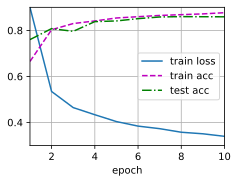

In [27]:
num_epochs=10
train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

### 简洁实现

#### 建立模型

- 在每个隐藏层之后添加一个`Dropout`层，将暂退概率作为唯一的参数传递给它

In [28]:
dropout1, dropout2 = 0.5, 0.5
net = nn.Sequential(nn.Flatten(),
        nn.Linear(784, 256),
        nn.ReLU(),
        nn.Dropout(dropout1),
        nn.Linear(256, 256),
        nn.ReLU(),
        nn.Dropout(dropout2),
        nn.Linear(256, 10))

- 在训练时，`Dropout`层将根据指定的暂退概率随机丢弃上一层的输出（相当于下一层的输入）
- 在检验时，`Dropout`层仅传递数据


#### 初始化参数

In [29]:
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01) # 从正态分布采样，均值为0，标准差为0.01

In [30]:
net.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=256, out_features=256, bias=True)
  (5): ReLU()
  (6): Dropout(p=0.5, inplace=False)
  (7): Linear(in_features=256, out_features=10, bias=True)
)

#### 建立优化器

In [31]:
trainer = torch.optim.SGD(net.parameters(), lr=lr)
# lr=0.5

#### 对模型进行训练和测试

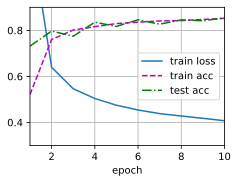

In [32]:
# loss = nn.CrossEntropyLoss(reduction='none')
# num_epochs = 10
train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

dropout和权重衰退实际上都是调整loss的方法。loss无论采用何种形式，当样本数过少的时候，都可能在局部将我们引导向错误的方向。

- 权重衰退，限制了权重的取值范围（不能没有边界），用权重不能没有界限来调整loss形式；本质上，不要让某些特征的权重过大。
- dropout给所有权重一个下边界，让其不能太小。